In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Use CUDA if available (HPC optimization)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
EPOCHS = 20
LATENT_DIM = 2  # Set to 2 for easy visualization (Task 6)

Using device: cuda


In [2]:
# Task 1: Dataset Preparation
transform = transforms.Compose([
    transforms.ToTensor(), # Converts to [0, 1]
])

# Download and load Fashion-MNIST
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 26.4M/26.4M [00:00<00:00, 114MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 2.19MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 36.7MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 29.9MB/s]


In [3]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()

        # --- Encoder Network [cite: 25] ---
        # Input: 28x28 = 784 pixels
        self.fc1 = nn.Linear(784, 400)
        self.relu = nn.ReLU()

        # Output two vectors: Mean (mu) and Log-Variance (log_var)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

        # --- Decoder Network  ---
        # Input: latent vector z
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)
        self.sigmoid = nn.Sigmoid() # Squish output between [0, 1] for image pixels

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        # Task 2: Reparameterization Trick
        std = torch.exp(0.5 * logvar) # Convert log_var to standard deviation
        eps = torch.randn_like(std)   # Sample random noise from standard normal
        return mu + eps * std         # z = mu + sigma * epsilon

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

model = VAE(latent_dim=LATENT_DIM).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [4]:
# Task 3: Define Loss Function [cite: 32]
def loss_function(recon_x, x, mu, logvar):
    # 1. Reconstruction Loss (Binary Cross Entropy)
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # 2. KL Divergence Loss
    # Formula: -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

Starting Training...
Epoch: 1 | Average Loss: 290.0057
Epoch: 2 | Average Loss: 273.0470
Epoch: 3 | Average Loss: 269.9648
Epoch: 4 | Average Loss: 268.3436
Epoch: 5 | Average Loss: 267.1931
Epoch: 6 | Average Loss: 266.2987
Epoch: 7 | Average Loss: 265.5935
Epoch: 8 | Average Loss: 264.9914
Epoch: 9 | Average Loss: 264.4389
Epoch: 10 | Average Loss: 263.8590
Epoch: 11 | Average Loss: 263.4632
Epoch: 12 | Average Loss: 262.9504
Epoch: 13 | Average Loss: 262.5959
Epoch: 14 | Average Loss: 262.2490
Epoch: 15 | Average Loss: 261.9031
Epoch: 16 | Average Loss: 261.6110
Epoch: 17 | Average Loss: 261.4056
Epoch: 18 | Average Loss: 261.1446
Epoch: 19 | Average Loss: 260.8295
Epoch: 20 | Average Loss: 260.6299


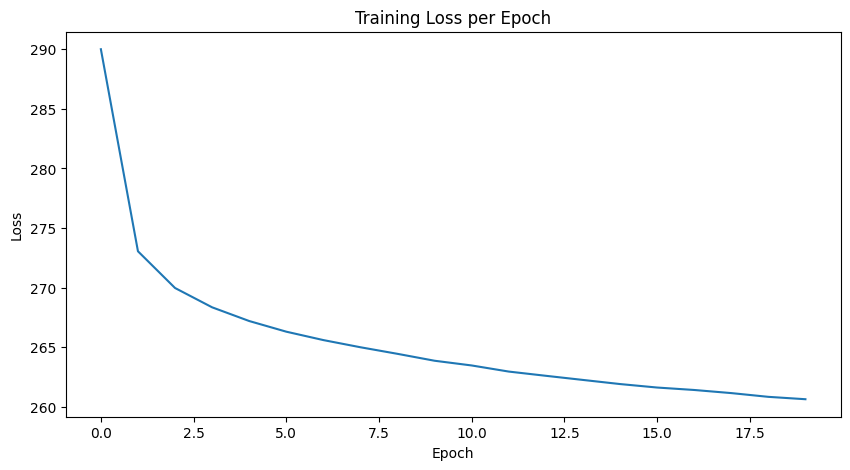

In [5]:
# Task 4: Train the VAE [cite: 33]
model.train()
train_losses = []

print("Starting Training...")
for epoch in range(EPOCHS):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)

        # Forward pass
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)

        # Compute loss
        loss = loss_function(recon_batch, data, mu, logvar)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    print(f'Epoch: {epoch+1} | Average Loss: {avg_loss:.4f}')

# Plot Loss Curve
plt.figure(figsize=(10,5))
plt.plot(train_losses)
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

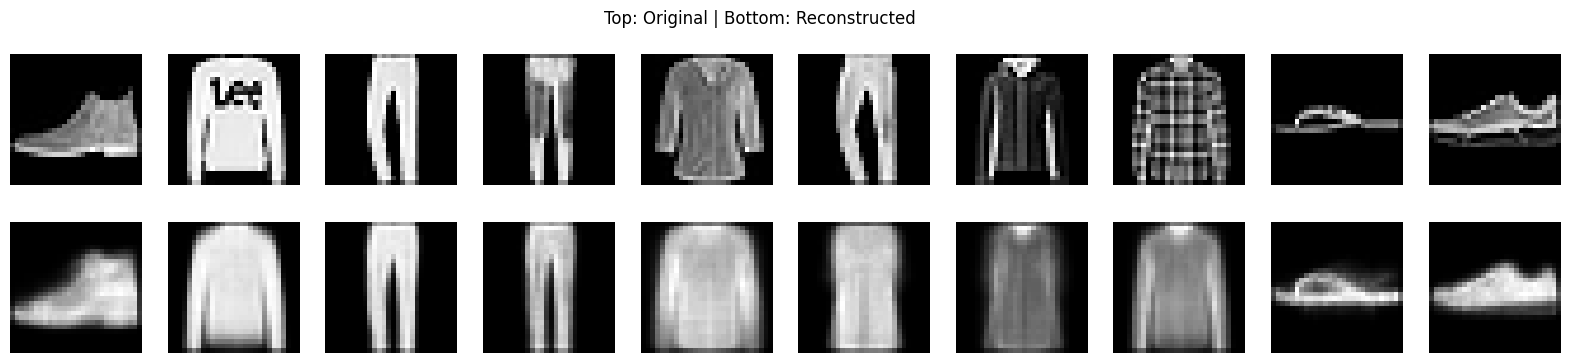

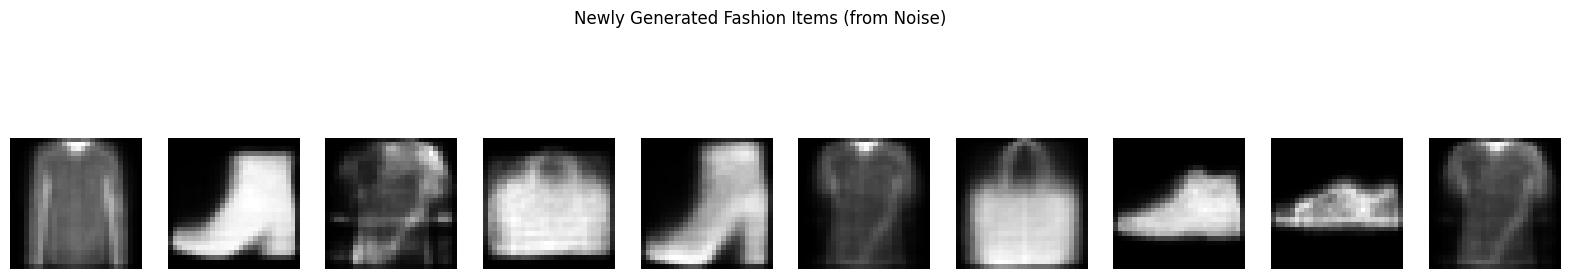

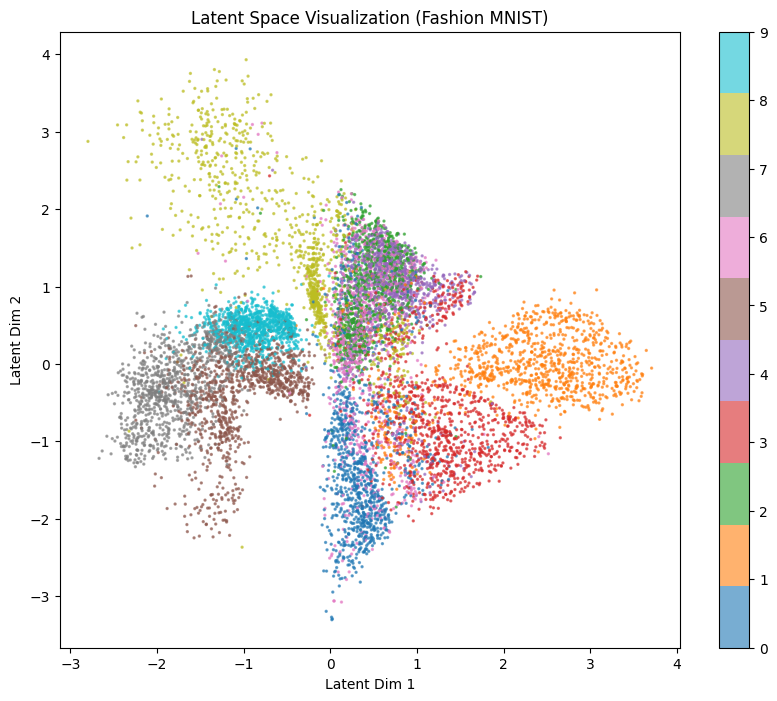

In [6]:
# Task 5: Sample Generation [cite: 36]
def visualize_results(model, test_loader, num_samples=10):
    model.eval()

    # 1. Reconstruction Check
    data, _ = next(iter(test_loader))
    data = data.to(device)
    with torch.no_grad():
        recon, _, _ = model(data)

    # Plot Original vs Reconstructed
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 4))
    for i in range(num_samples):
        # Original
        axes[0, i].imshow(data[i].cpu().numpy().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        # Reconstructed
        axes[1, i].imshow(recon[i].cpu().view(28, 28).numpy(), cmap='gray')
        axes[1, i].axis('off')
    plt.suptitle("Top: Original | Bottom: Reconstructed")
    plt.show()

    # 2. Generate NEW Samples from Random Noise [cite: 37-39]
    with torch.no_grad():
        # Sample random vectors from standard normal distribution
        z = torch.randn(num_samples, LATENT_DIM).to(device)
        generated_images = model.decode(z).cpu().view(num_samples, 28, 28)

    plt.figure(figsize=(20, 4))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(generated_images[i], cmap='gray')
        plt.axis('off')
    plt.suptitle("Newly Generated Fashion Items (from Noise)")
    plt.show()

# Task 6: Latent Space Visualization (Optional) [cite: 40-42]
def plot_latent_space(model, test_loader):
    model.eval()
    all_z = []
    all_labels = []

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            mu, _ = model.encode(data.view(-1, 784))
            all_z.append(mu.cpu())
            all_labels.append(labels)

    all_z = torch.cat(all_z).numpy()
    all_labels = torch.cat(all_labels).numpy()

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(all_z[:, 0], all_z[:, 1], c=all_labels, cmap='tab10', alpha=0.6, s=2)
    plt.colorbar(scatter)
    plt.title("Latent Space Visualization (Fashion MNIST)")
    plt.xlabel("Latent Dim 1")
    plt.ylabel("Latent Dim 2")
    plt.show()

# Run Visualizations
visualize_results(model, test_loader)
plot_latent_space(model, test_loader)

In [ ]:
Changed code

# New Section

Using device: cuda

--- Starting Training: KLD DISABLED ---
Epoch 1/10 | BCE Loss: 275.73
Epoch 2/10 | BCE Loss: 262.37
Epoch 3/10 | BCE Loss: 259.65
Epoch 4/10 | BCE Loss: 258.09
Epoch 5/10 | BCE Loss: 257.02
Epoch 6/10 | BCE Loss: 256.11
Epoch 7/10 | BCE Loss: 255.37
Epoch 8/10 | BCE Loss: 254.76
Epoch 9/10 | BCE Loss: 254.17
Epoch 10/10 | BCE Loss: 253.68

--- Starting Training: KLD ENABLED ---
Epoch 1/10 | BCE Loss: 277.54
Epoch 2/10 | BCE Loss: 264.39
Epoch 3/10 | BCE Loss: 261.63
Epoch 4/10 | BCE Loss: 260.07
Epoch 5/10 | BCE Loss: 258.91
Epoch 6/10 | BCE Loss: 258.14
Epoch 7/10 | BCE Loss: 257.58
Epoch 8/10 | BCE Loss: 257.08
Epoch 9/10 | BCE Loss: 256.65
Epoch 10/10 | BCE Loss: 256.26


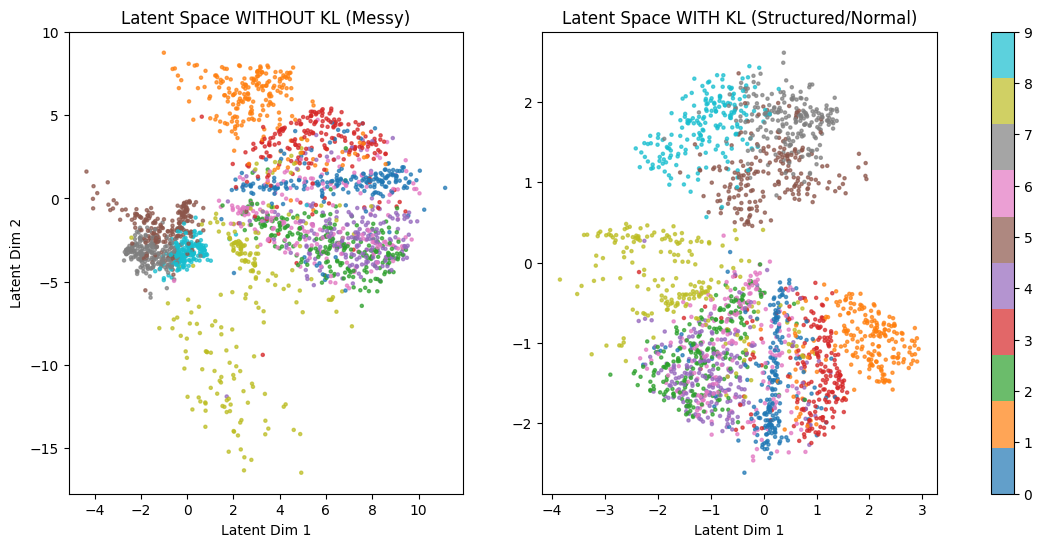

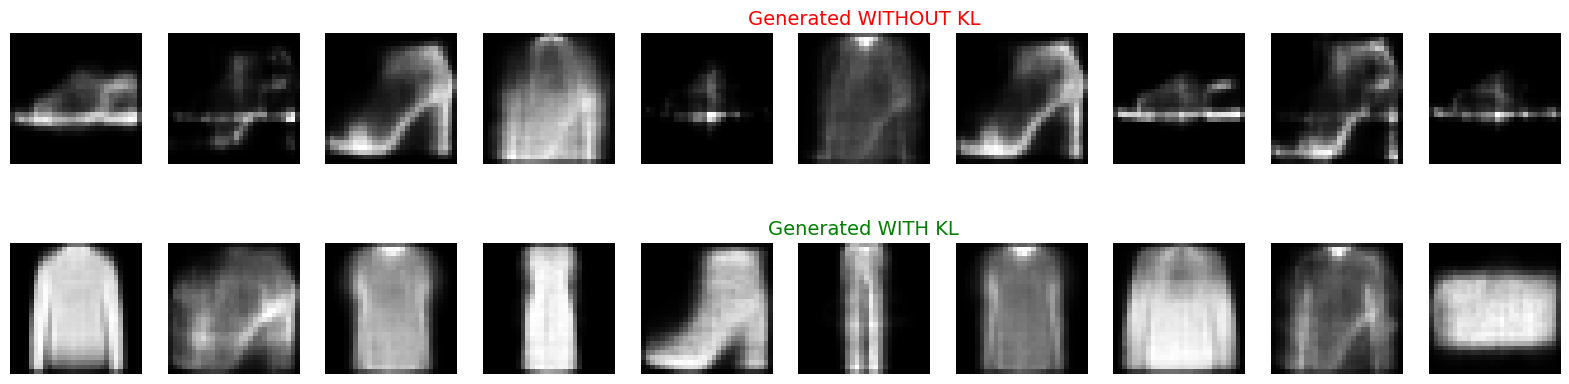

Final BCE Loss (Without KL): 253.68 (Focuses only on memorization)
Final BCE Loss (With KL):    256.26 (Slightly higher tradeoff for valid generation)


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# HPC Optimization: Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 1. Dataset Preparation [cite: 20-23] ---
BATCH_SIZE = 64
transform = transforms.Compose([transforms.ToTensor()])

# Download Fashion-MNIST [cite: 46]
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- 2. VAE Architecture [cite: 24-28] ---
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(784, 400)
        self.relu = nn.ReLU()
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc_mu(h1), self.fc_logvar(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# --- 3. Training Function (Toggle KLD on/off) ---
def train_experiment(use_kld=True, epochs=10):
    model = VAE(latent_dim=2).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    bce_history = []

    print(f"\n--- Starting Training: KLD {'ENABLED' if use_kld else 'DISABLED'} ---")

    for epoch in range(epochs):
        total_bce = 0
        model.train()
        for data, _ in train_loader:
            data = data.to(device)
            optimizer.zero_grad()

            recon_batch, mu, logvar = model(data)

            # Reconstruction Loss (Cross Entropy) [cite: 30]
            BCE = nn.functional.binary_cross_entropy(recon_batch, data.view(-1, 784), reduction='sum')

            # KL Divergence [cite: 31]
            if use_kld:
                KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            else:
                KLD = torch.tensor(0.0).to(device) # Disable KLD

            loss = BCE + KLD
            loss.backward()
            optimizer.step()

            total_bce += BCE.item()

        avg_bce = total_bce / len(train_loader.dataset)
        bce_history.append(avg_bce)
        print(f"Epoch {epoch+1}/{epochs} | BCE Loss: {avg_bce:.2f}")

    return model, bce_history

# --- Run Both Experiments ---
# 1. Without KL (Standard Autoencoder behavior)
model_no_kl, loss_no_kl = train_experiment(use_kld=False, epochs=10)

# 2. With KL (VAE behavior)
model_with_kl, loss_with_kl = train_experiment(use_kld=True, epochs=10)

# --- 4. Visualization & Comparison [cite: 39-42] ---
def compare_latent_space(model_no_kl, model_with_kl, loader):
    model_no_kl.eval()
    model_with_kl.eval()

    z_no_kl, labels_list = [], []
    z_with_kl = []

    with torch.no_grad():
        for data, labels in loader:
            data = data.to(device)
            # Encode data to latent space
            mu_no, _ = model_no_kl.encode(data.view(-1, 784))
            mu_with, _ = model_with_kl.encode(data.view(-1, 784))

            z_no_kl.append(mu_no.cpu())
            z_with_kl.append(mu_with.cpu())
            labels_list.append(labels)

            if len(z_no_kl) * BATCH_SIZE > 2000: break # Only plot 2000 points

    z_no_kl = torch.cat(z_no_kl).numpy()
    z_with_kl = torch.cat(z_with_kl).numpy()
    labels = torch.cat(labels_list).numpy()

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot No KL
    scatter1 = axes[0].scatter(z_no_kl[:, 0], z_no_kl[:, 1], c=labels, cmap='tab10', s=5, alpha=0.7)
    axes[0].set_title("Latent Space WITHOUT KL (Messy)")
    axes[0].set_xlabel("Latent Dim 1")
    axes[0].set_ylabel("Latent Dim 2")

    # Plot With KL
    scatter2 = axes[1].scatter(z_with_kl[:, 0], z_with_kl[:, 1], c=labels, cmap='tab10', s=5, alpha=0.7)
    axes[1].set_title("Latent Space WITH KL (Structured/Normal)")
    axes[1].set_xlabel("Latent Dim 1")

    plt.colorbar(scatter2, ax=axes.ravel().tolist())
    plt.show()

def compare_generation(model_no_kl, model_with_kl):
    # Generate from pure noise (Standard Normal)
    z = torch.randn(10, 2).to(device)

    with torch.no_grad():
        gen_no_kl = model_no_kl.decode(z).cpu().view(10, 28, 28)
        gen_with_kl = model_with_kl.decode(z).cpu().view(10, 28, 28)

    fig, axes = plt.subplots(2, 10, figsize=(20, 5))
    for i in range(10):
        # No KL Generation (Usually Garbage)
        axes[0, i].imshow(gen_no_kl[i], cmap='gray')
        axes[0, i].axis('off')
        if i == 5: axes[0, i].set_title("Generated WITHOUT KL", fontsize=14, color='red')

        # With KL Generation (Valid Clothes)
        axes[1, i].imshow(gen_with_kl[i], cmap='gray')
        axes[1, i].axis('off')
        if i == 5: axes[1, i].set_title("Generated WITH KL", fontsize=14, color='green')

    plt.show()

# Execute comparisons
compare_latent_space(model_no_kl, model_with_kl, test_loader)
compare_generation(model_no_kl, model_with_kl)

# Print Final Loss Comparison
print(f"Final BCE Loss (Without KL): {loss_no_kl[-1]:.2f} (Focuses only on memorization)")
print(f"Final BCE Loss (With KL):    {loss_with_kl[-1]:.2f} (Slightly higher tradeoff for valid generation)")